In [34]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker
from matplotlib import cm 
from matplotlib.table import Table
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from fractions import Fraction
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

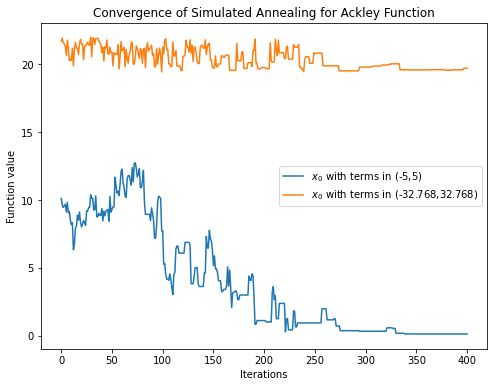

In [30]:
def ackley(x):
    term1 = -0.2 * np.sqrt(0.5 * (x[0]**2 + x[1]**2))
    term2 = 0.5 * (np.cos(2*np.pi*x[0]) + np.cos(2*np.pi*x[1]))
    return -20*np.exp(term1) - np.exp(term2) + 20 + np.e

def simulated_annealing_1(starting_vector, sa_kwargs={}, niter=400, T=5, stepsize=0.4):
    """
    Minimize a function using simulated annealing.
    """
    curr_x = starting_vector
    curr_energy = ackley(curr_x)
    curr_T = T
    x_history = [starting_vector]
    energy_history = [curr_energy]
    for i in range(niter):
        new_x = curr_x + stepsize * np.random.normal(size=starting_vector.shape)
        new_energy = ackley(new_x)
        if new_energy < curr_energy:
            curr_x = new_x
            curr_energy = new_energy
        else:
            delta_energy = new_energy - curr_energy
            acceptance_prob = np.exp(-delta_energy / curr_T)
            if np.random.random() < acceptance_prob:
                curr_x = new_x
                curr_energy = new_energy
        curr_T = curr_T * 0.99
        x_history.append(curr_x)
        energy_history.append(curr_energy)
    return {'x': curr_x, 'fun': curr_energy, 'x_history': x_history, 'energy_history': energy_history, 'nit': niter}

# Generate random starting vectors
start_vec1 = np.random.uniform(-5, 5, size=100)
start_vec2 = np.random.uniform(-32.768, 32.768, size=100)

# Run SA with different starting vectors
sa_result1 = simulated_annealing_1(start_vec1)
sa_result2 = simulated_annealing_1(start_vec2)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(sa_result1['energy_history'], label=r"$x_{0}$ with terms in (-5,5)")
plt.plot(sa_result2['energy_history'], label=r"$x_{0}$ with terms in (-32.768,32.768)")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Function value")
plt.title("Convergence of Simulated Annealing for Ackley Function")
plt.show()

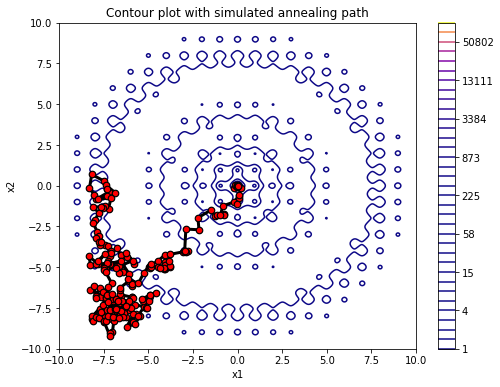

In [31]:
# Set up the bounds and starting vector
bounds = [(-10, 10) for _ in range(2)]
x0_2 = np.random.uniform(-10, 10, size=2)

# Set up the L-BFGS-B optimizer for simulated annealing
sa_kwargs = {"method": "L-BFGS-B", "bounds": bounds}

# Set up the optimization function for simulated annealing
def simulated_annealing_2(starting_vector, sa_kwargs={}, niter=1000, T=5.0, stepsize=0.4):
    x_history = [starting_vector]
    curr_x = starting_vector
    curr_energy = ackley(curr_x)
    curr_T = T
    energy_history = [curr_energy]

    for i in range(niter):
        candidate_x = curr_x + stepsize * np.random.randn(2)
        if (candidate_x < np.array(bounds)[:, 0]).any() or (candidate_x > np.array(bounds)[:, 1]).any():
            candidate_x = np.clip(candidate_x, np.array(bounds)[:, 0], np.array(bounds)[:, 1])
        candidate_energy = ackley(candidate_x)
        delta_E = candidate_energy - curr_energy
        if delta_E < 0 or np.exp(-delta_E / curr_T) > np.random.rand():
            curr_x = candidate_x
            curr_energy = candidate_energy
            x_history.append(curr_x)
            energy_history.append(curr_energy)
        curr_T *= 0.99

    res = minimize(ackley, curr_x, method="L-BFGS-B", bounds=bounds)
    return res, x_history

# Run the simulated annealing algorithm
sa_result2, sa_path2 = simulated_annealing_2(x0_2, sa_kwargs)

# Generate the contour plot
x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i, j] = ackley(np.array([X[i, j], Y[i, j]]))

plt.figure(figsize=(8, 6))
CS = plt.contour(X, Y, Z, levels=np.logspace(0, 5, 35), cmap='plasma')
plt.colorbar(CS)
plt.plot([s[0] for s in sa_path2], [s[1] for s in sa_path2], '-', linewidth=3, color='black')
plt.plot([s[0] for s in sa_path2], [s[1] for s in sa_path2], '.', markersize=13, linewidth=1, color='red', markeredgecolor='black', markeredgewidth=1.2)
plt.title('Contour plot with simulated annealing path')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [32]:
# Define the Ackley function with d=100 dimensions
def ackley_100(x):
    d = x.shape[1]
    a = 20
    b = 0.2
    c = 2 * np.pi

    sum_sq_term = -a * np.exp(-b * np.sqrt(1.0 / d * np.sum(x ** 2, axis=1)))
    cos_term = -np.exp(1.0 / d * np.sum(np.cos(c * x), axis=1))

    return a + np.exp(1) + sum_sq_term + cos_term

2023-05-24 23:05:57,235 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.95}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=11.5
2023-05-24 23:06:02,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 11.45883250535387, best pos: [-5.86284904e+00 -6.06597642e+00  2.14205306e+00 -2.85643080e+00
  9.96010180e-01  3.90803930e+00  9.69584210e-01  2.84846256e+00
  9.08701426e+00 -2.94016880e+00 -2.99441680e+00  3.11991882e+00
 -7.10057560e-03  5.01801968e+00  4.01025929e+00  6.65098806e-03
  1.97400565e+00  3.09270689e-01  1.01677448e+00  1.98381699e+00
 -1.00542862e+00  4.95485076e+00  9.60034601e-01 -1.10939596e-01
 -2.04414716e+00 -1.12014481e+00  2.87799544e-02 -1.10360060e+00
 -4.98735701e+00  9.84956560e-01 -1.17381767e-01 -4.03678835e+00
  4.43900901e+00  2.40620481e+00 -9.76703702e-01  6.98288542e+00
 -4.25898511e+00  2.86628773e+00 -2.54517666e+00  2.16438638e-02
 -2.01419408e+00 -1.936927

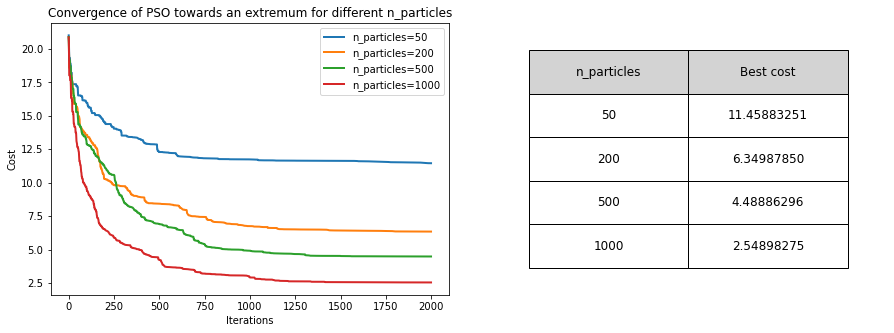

In [35]:
# Set up the hyperparameters for the PSO algorithm
options = {
    'c1': 0.5,  # cognitive coefficient
    'c2': 0.3,  # social coefficient
    'w': 0.95,   # inertia weight
}

# Create bounds for the search space
bounds = (-32.768 * np.ones(100), 32.768 * np.ones(100))

# Define the number of particles to test
n_particles_list = [50, 200, 500, 1000]

# Initialize the cost_history_dict and best_cost_dict
cost_history_dict = {}
best_cost_dict = {}

# Loop through the n_particles list
for n_particles in n_particles_list:
    # Instantiate the optimizer
    optimizer = ps.single.GlobalBestPSO(
        n_particles=n_particles, dimensions=100, options=options, bounds=bounds
    )

    # Run the optimization
    cost, pos = optimizer.optimize(ackley_100, iters=2000)

    # Retrieve the cost history
    cost_history_dict[n_particles] = optimizer.cost_history

    # Store the best cost
    best_cost_dict[n_particles] = cost
    
# Plot the convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.1)
for n_particles, cost_history in cost_history_dict.items():
    ax1.plot(cost_history, linewidth=2, label=f'n_particles={n_particles}')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cost')
ax1.set_title('Convergence of PSO towards an extremum for different n_particles')
ax1.legend()

# Create the table
table_data = [['n_particles', 'Best cost']]
for n_particles, best_cost in best_cost_dict.items():
    table_data.append([n_particles, f"{best_cost:.8f}"])

table = Table(ax2, bbox=[0.1, 0.1, 0.8, 0.8])

cell_width, cell_height = 0.4, 0.2

for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        if i == 0:
            table.add_cell(i, j, cell_width, cell_height, text=cell, loc='center', facecolor='lightgray')
        else:
            table.add_cell(i, j, cell_width, cell_height, text=cell, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)

ax2.add_table(table)
ax2.axis('off')

plt.show()

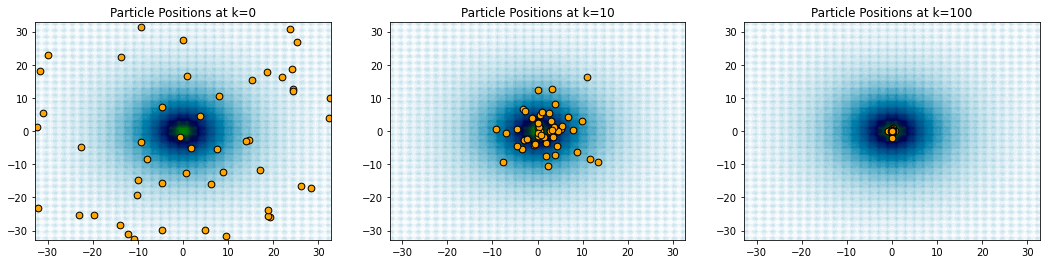

In [41]:
# Define the Ackley function
def ackley_2(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = x.shape[-1]
    
    sum_sq_term = -a * np.exp(-b * np.sqrt(np.sum(x**2, axis=-1) / d))
    cos_term = -np.exp(np.sum(np.cos(c * x), axis=-1) / d)
    return a + np.exp(1) + sum_sq_term + cos_term

# Set up the PSO options
options = {"c1": 0.5, "c2": 0.3, "w": 0.9}
bounds = (np.array([-32.768, -32.768]), np.array([32.768, 32.768]))

# Initialize the optimizer
optimizer = GlobalBestPSO(n_particles=50, dimensions=2, options=options, bounds=bounds)

# Run the optimization
cost, pos = optimizer.optimize(ackley_2, iters=100, verbose=False)
    
def plot_contour(ax, positions, title):
    X, Y = np.meshgrid(np.linspace(-32.768, 32.768, 100), np.linspace(-32.768, 32.768, 100))
    Z = ackley_2(np.stack([X, Y], axis=-1))
    contour_levels = np.linspace(Z.min(), Z.max(), 50)
    ax.contourf(X, Y, Z, levels=contour_levels, cmap="ocean")
    ax.scatter(positions[:, 0], positions[:, 1], color="orange", marker="o", s=45, edgecolors="black")
    ax.set_title(title)

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Plot the initial, middle, and final particle positions
plot_contour(axes[0], optimizer.pos_history[0], "Particle Positions at k=0")
plot_contour(axes[1], optimizer.pos_history[10], "Particle Positions at k=10")
plot_contour(axes[2], optimizer.pos_history[-1], "Particle Positions at k=100")

# Display the figure
plt.show()